In [3]:
import numpy as np
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt

# Setup

Files:

In [9]:
DATA_DIR = "../data"
SO_DIR = DATA_DIR + "/soErrors.log" #original snippets
SO_AFTER_DIR = DATA_DIR + "/soErrorsAfter.log" #snippets after edits

#reduction in errors ONLY set
SO_IMPROVE_DIR = DATA_DIR + "/soErrorsImprove.log" #original snippets
SO_IMPROVE_AFTER_DIR = DATA_DIR + "/soErrorsImproveAfter.log" #snippets after edits

#fixed ONLY set
SO_FIXED_DIR = DATA_DIR + "/soErrorsFixed.log" #original snippets
SO_FIXED_AFTER_DIR = DATA_DIR + "/soErrorsFixedAfter.log" #snippets after edits


## Error Labels

In [5]:
# error dict
error_labels = {
    "Cannot find name 'clone'. Did you mean 'close'?" : "Cannot find name (suggestion).",
    "Cannot find name 'requires'. Did you mean 'require'?" : "Cannot find name (suggestion).",
    "Cannot find name 'One'. Did you mean 'one'?": "Cannot find name (suggestion).",
    "Cannot find name '$DOMAIN'. Did you mean 'DOMAIN'?": "Cannot find name (suggestion).",
    "Cannot use JSX unless the '--jsx' flag is provided." : "JSX",
    "Left side of comma operator is unused and has no side effects." : "Left side comma operator unused",
    "Type annotations can only be used in TypeScript files." : "Type annotations",
    "A 'return' statement can only be used within a function body.": "Return outside function",
    "Property 'setState' does not exist on type 'UnicornEditor'.": "Property doesn't exist on type",
    "Property 'returns' does not exist on type '(arg0: any) => void'." : "Property doesn't exist on type", #first error message the values r specific
    "Property 'log' does not exist on type '(arg0: any) => void'." : "Property doesn't exist on type", #first error message the values r specific
    "Top-level 'await' expressions are only allowed when the 'module' option is set to 'es2022' 'esnext' 'system' 'node16' or 'nodenext' and the 'target' option is set to 'es2017' or higher.": "Top level await",
    "Cannot find name 'it'. Do you need to install type definitions for a test runner? Try `npm i --save-dev @types/jest` or `npm i --save-dev @types/mocha` and then add 'jest' or 'mocha' to the types field in your tsconfig.": "Cannot find name (it).",
    "Parsing error: Unexpected token": "Parsing.unexpectedToken",
    "Parsing error: 'import' and 'export' may appear only with 'sourceType: module'": "Parsing.importExport",
    "Parsing error: Unexpected character": "Parsing.unexpectedCharacter",
    "Parsing error: Identifier has already been declared": "Parsing.alreadyDeclared",
    "Parsing error: Invalid regular expression" : "Parsing.invalidRegEx",
    "Parsing error: Assigning to rvalue": "Parsing.assignedToRvalue",
    "Parsing error: Unterminated regular expression": "Parsing.unterminatedRegEx",
    "Parsing error: Identifier directly after number": "Parsing.identifierAfterNumber",
    "Parsing error: Unterminated string constant": "Parsing.unterminatedStringConstant",
    "Parsing error: Expecting Unicode escape sequence \\uXXXX":  "Parsing.expectedUnicodeEscape",
    "Parsing error: Cannot use keyword 'await' outside an async function": "Parsing.awaitNotInAsync",
    "Parsing error: Reserved keyword" : "Parsing.reservedKeyword",
    "Parsing error: 'return' outside of function" : "Parsing.returnNotInFunction",
    "Parsing error: Unterminated template": "Parsing.unterminatedTemplate",
}

def getLabels(errors):
    errors = list(errors)
    for i, e in enumerate(errors):
        if e in error_labels:
            e = error_labels[e]
        else:
            if e.endswith("."):
                e = e[:-1]
        errors[i] = e
    return errors

## Classes

In [6]:
class Log:

    def __init__(self, filename, heading = "ERROR, CODE, CATEGORY, NUM OCCURANCES, NUM AFFECTED SNIPPETS, FIRST ID, PERCENT"):
        rows = []
        self.snippets = None
        self.noErrors = None
        self.totalErrors = None
        self.fixed = None
        self.empty = None
        self.loc = None

        if isinstance(filename, str):
            file = open(filename, encoding="utf8")
            lines = file.readlines()
        else:
            lines = filename

        headings = []
        csv_mode = False
        for line in lines:
            line = line.strip()
            if line.startswith(heading):
                csv_mode = True
                headings = line.split(",")
                headings = [h.strip() for h in headings]
                continue
            if(csv_mode):
                if not line:
                    csv_mode = False
                    continue
                parts = line.split(",")
                to = len(headings)-1
                columns = ["".join(parts[0:-to])]
                for p in parts[-to:]:
                    p = p.strip()
                    if p == "true":
                        p = True
                    elif p == "undefined":
                        p = False
                    elif p == "":
                        p = None
                    else:
                        p = float(p)
                    columns.append(p)
                # columns += [float(p.strip()) for p in parts[-to:]]
                rows.append(columns)
                continue
            if line.startswith("Snippets without errors:"):
                self.noErrors = int(line.split(":")[1].split("/")[0])
            if(line.startswith("Total errors:")):
                self.totalErrors = int(line.split(":")[1])
            if(line.startswith("Fixed:")):
                self.fixed = int(line.split(":")[1].split("/")[0])
            if(line.startswith("Code lines:")):
                self.loc = int(line.split(":")[1])
            if(line.startswith("Snippets no lines:")):
                self.empty = int(line.split(":")[1].split("/")[0])
            if line.startswith("TOTAL SNIPPETS:"):
                self.snippets = int(line.split(":")[1].strip())
        
        self.errors = DataFrame.from_records(rows, columns=headings)

    def getLines(filename, heading, end):
        file = open(filename, encoding="utf8")
        lines = file.readlines()
        record = True
        newLines = []
        for line in lines:
            if line.startswith("--------"):
                record = False
            if line.startswith(heading):
                record = True
            if end and line.startswith(end):
                reocrd = False
            if record:
                newLines.append(line)
        return newLines
    

## Functions

In [7]:
# figures

fig_height = 3.5

#i cant spell occurrences...
def top10Errors(df, column, label="Occurrences (million)", title="Common Error Types", saveas='commonErrorTypes', getLabels=getLabels, xlim=8000000, format=lambda x, p: format(int(x/1000000), ','), color = "ncc", df2 = None):
    if color == "ncc": color = "darkorange"
    elif color == "ncq": color = "darkblue"
    
    top10_df = df.nlargest(10, [column]).iloc[::-1]
    top10_df2 = None
    if(isinstance(df2, DataFrame)): 
        index = "CODE"
        # get the same values
        keys = list(top10_df[index])
        if None in keys:
            index = "ERROR"
            keys = list(top10_df[index])
        top10_df2 = df2[df2[index].isin(keys)].iloc[::-1]
        top10_df2 = top10_df2.set_index(index)
        top10_df2 = top10_df2.reindex(keys)
        top10_df2 = top10_df2.reset_index()
        

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex="col", width_ratios=[3, 2])
    fig.set_size_inches(4, fig_height)

    ax1.barh(getLabels(top10_df["ERROR"]), top10_df[column], color=color)
    if(isinstance(df2, DataFrame)): ax1.barh(getLabels(top10_df2["ERROR"]), top10_df2[column], color=(0,0,0,0.3))
    ax = ax2.barh(range(0, 10), top10_df[column], color=color)
    if(isinstance(df2, DataFrame)): ax2.barh(range(0, 10), top10_df2[column], color=(0,0,0,0.3))

    fig.subplots_adjust(wspace=0.15)

    ax1.set_xlim(0, 800000)
    ax2.set_xlim(1000000, 9500000)

    ax1.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.tick_params(labelleft=False, left=False)
    ax2.yaxis.tick_right()

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)

    ax1.set_xlabel(label, x=1)
    ax1.set_ylabel("Errors")
    # ax.set_xlim(0, xlim)
    

    ax1.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: x/1000000))
    ax2.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: x/1000000))

    # ax2.get_xaxis().set_major_formatter(
    #     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/100), ',')))
    # ax1.tick_params(axis='both', which='major', labelsize=8.5)
    #fig.set_title(title)

    labels = []
    for n in top10_df[column]:
        if(n>1000000):
            n = str(round(n/1000000, 1)) + "m"
        else:
            n = int(n)
        labels.append(n)
    ax2.bar_label(ax, label_type='edge', labels=labels, padding=1, size=8)
    ax1.bar_label(ax, label_type='edge', labels=labels, padding=1, size=8)
    plt.savefig(saveas, bbox_inches = "tight")
    plt.show()

## Load

In [10]:
so_errors = Log(Log.getLines(SO_DIR, "ERROR ANALYSIS", None))
soa_errors = Log(Log.getLines(SO_AFTER_DIR, "ERROR ANALYSIS", None))

soi_errors = Log(Log.getLines(SO_IMPROVE_DIR, "ERROR ANALYSIS", None))
soia_errors = Log(Log.getLines(SO_IMPROVE_AFTER_DIR, "ERROR ANALYSIS", None))

sof_errors = Log(Log.getLines(SO_FIXED_DIR, "ERROR ANALYSIS", None))
sofa_errors = Log(Log.getLines(SO_FIXED_AFTER_DIR, "ERROR ANALYSIS", None))

# Errors

## All Edits

How many errors between original and most recent?

In [11]:
def overview(e, c = None):
    print("Total Snippets:", str(e.snippets))
    print("Total Errors:", str(e.totalErrors))
    if c:
        print("Error Difference (+/-):", str(-(c.totalErrors - e.totalErrors)))
    print("Average:", str(
        e.totalErrors / e.snippets
    ))
    print("Total LOC:", str(e.loc))
    if c:
        locdif = -(e.loc - c.loc)
        print("LOC Difference (+/-):", str(-(c.loc - e.loc)))
    print("Snippets with no Errors:", str(e.noErrors), "/", str(e.snippets), "(", str(e.noErrors/e.snippets), ")")
    if c:
        print("Snippets with no Errors Difference (+/-): " + str(-(c.noErrors - e.noErrors)))
        print("Snippets increased by: " + str(
            (e.noErrors - c.noErrors)/ c.noErrors
        ))
    wE = e.snippets-e.noErrors
    print("Snippets with Errors: " + str(wE) + "/" + str(e.snippets) + "(" + str(1 - e.noErrors/e.snippets) + ")")
    if c:
         wEc = c.snippets-c.noErrors
         print("Snippets with Errors Difference (+/-): " + str(-(wEc - wE)))
    print("Average for Error Set: " + str(
        e.totalErrors / wE
    ))
    print("Snippets Fixed " + str(e.fixed) + "/" + str(e.snippets) + "(" + str(e.fixed/e.snippets) + ")")
    if c:
        fixdif = e.fixed - c.fixed
        print("Snippets Fixed Difference (+/-): " + str(-(c.fixed - e.fixed)))
        if fixdif:
            print("Average Deleted per Fixed: " + str(locdif/fixdif))
    print("Snippets Empty " + str(e.empty) + "/" + str(e.snippets) + "(" + str(e.empty/e.snippets) + ")")
    if c:
        emptydif = e.empty - c.empty
        print("Snippets Empty Difference (+/-): " + str(emptydif))
        print("Snippets No Error Non-Empty " + str((e.noErrors - c.noErrors)-emptydif) + "/" + str((e.noErrors - c.noErrors)) + "(" + str(((e.noErrors - c.noErrors)-emptydif)/(e.noErrors - c.noErrors)) + ")")


def p_increase(o, n, what):
    '''
    For original and new value, print p increase.
    '''
    diff = n-o
    p = diff/o
    print("Percentage Increase of", what, ":", round(p*100, 2), "% (", diff, ")")

se_df = so_errors.errors
sea_df = soa_errors.errors
overview(so_errors)
print()
overview(soa_errors)

print("\n")
p_increase(so_errors.loc, soa_errors.loc, "LOC")

Total Snippets: 20578
Total Errors: 286352
Average: 13.915443677714064
Total LOC: 248913
Snippets with no Errors: 0 / 20578 ( 0.0 )
Snippets with Errors: 20578/20578(1.0)
Average for Error Set: 13.915443677714064
Snippets Fixed 0/20578(0.0)
Snippets Empty 2/20578(9.719117504130625e-05)

Total Snippets: 20578
Total Errors: 367536
Average: 17.860627854990767
Total LOC: 283144
Snippets with no Errors: 1178 / 20578 ( 0.05724560209932938 )
Snippets with Errors: 19400/20578(0.9427543979006706)
Average for Error Set: 18.945154639175257
Snippets Fixed 0/20578(0.0)
Snippets Empty 8/20578(0.000388764700165225)


Percentage Increase of LOC : 13.75 % ( 34231 )


Total errors increase, but 1,178 snippets go from errors to none. There is, however, a ~34,231 line increase.

### Most Common Types

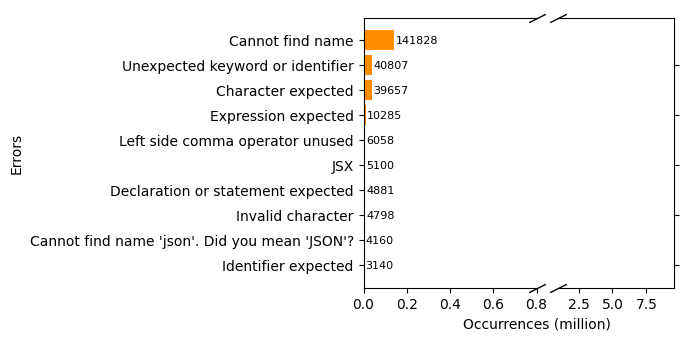

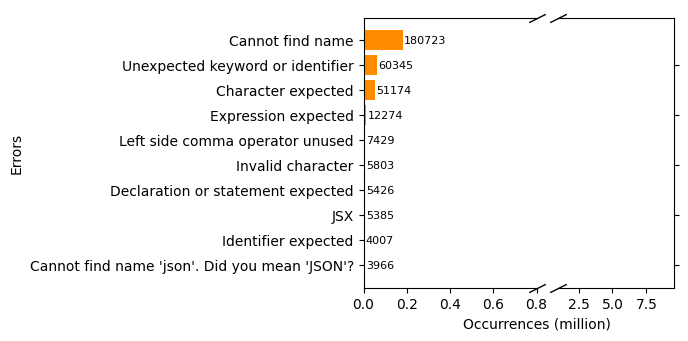

In [12]:
top10Errors(se_df, "NUM OCCURANCES", saveas="so_errorTypes", xlim=700000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Errors",
    color = "ncc")

top10Errors(sea_df, "NUM OCCURANCES", saveas="sof_errorTypes", xlim=700000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Errors",
    color = "ncc")

## Edits with Improvement only

In [15]:
sei_df = soi_errors.errors
seia_df = soia_errors.errors
overview(soi_errors)
print()
overview(soia_errors)

print("\n")
p_increase(soi_errors.loc, soia_errors.loc, "LOC")
p_increase(soi_errors.totalErrors, soia_errors.totalErrors, "LOC")

Total Snippets: 15137
Total Errors: 157252
Average: 10.388584263724649
Total LOC: 182088
Snippets with no Errors: 0 / 15137 ( 0.0 )
Snippets with Errors: 15137/15137(1.0)
Average for Error Set: 10.388584263724649
Snippets Fixed 0/15137(0.0)
Snippets Empty 1/15137(6.606328863050802e-05)

Total Snippets: 15137
Total Errors: 123893
Average: 8.184779018299531
Total LOC: 187865
Snippets with no Errors: 1178 / 15137 ( 0.07782255400673846 )
Snippets with Errors: 13959/15137(0.9221774459932616)
Average for Error Set: 8.875492513790386
Snippets Fixed 0/15137(0.0)
Snippets Empty 8/15137(0.0005285063090440642)


Percentage Increase of LOC : 3.17 % ( 5777 )
